In [2]:
pip install matplotlib numpy pandas tensorflow scikit-learn keras

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/7d/18/95ae2e242d4a5c98bd6e90e36e128d71cf1c7e39b0874feaed3ef782e789/matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/e5/63/cd7d615331b328e287d8233ba9fdf191a9c2d11b6af0c7a59cfcec23de68/pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/5c/d0/0c577d9325b05594fdd33aa970bf53fb673f051a45496842caee13cfd7fe/scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/cc/8f/ec6289987824b29529d0dfda0d74a07cec60e54b9c92f3c9da4c0ac732de/cont

In [7]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential #Initialise our neural network model as a sequential network
from keras.layers import Conv2D #Convolution operation
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation#Applies activation function
from keras.layers import Dropout#Prevents overfitting by randomly converting few outputs to zero
from keras.layers import MaxPooling2D # Maxpooling function
from keras.layers import Flatten # Converting 2D arrays into a 1D linear vector
from keras.layers import Dense # Regular fully connected neural network
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
from sklearn.metrics import accuracy_score

2025-10-16 12:12:20.666950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 12:12:20.718750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 12:12:22.786817: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 12:12:25.948577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

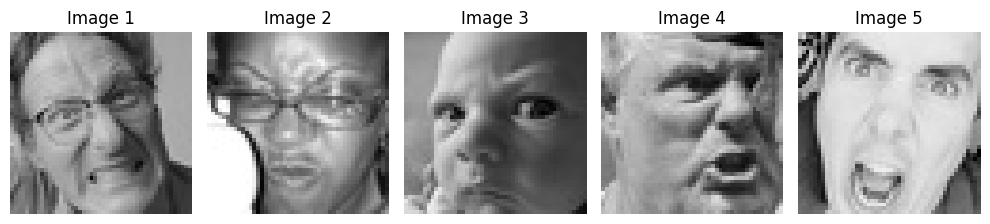

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# Base folder (adjust if necessary)
image_path = '/home/clyde/emotion-CV/datasets/fer2013/test/angry/'

# Get all image filenames in that folder
image_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jpg')]

# Show first 5 images
plt.figure(figsize=(10, 5))
for i, img_file in enumerate(image_files[:5]):
    img_array = cv2.imread(img_file)
    if img_array is None:
        print(f"❌ Could not read: {img_file}")
        continue

    img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i+1)
    plt.imshow(img_rgb)
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
def load_data(path): #Run once
  
    #classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']  

    data = []
    test_data = []
    test_labels = []
    labels =[]

    with open(path, 'r') as file:
        for line_no, line in enumerate(file.readlines()):
            if 0 < line_no <= 35887:
                curr_class, line, set_type = line.split(',')
                image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)#Creating a list out of the string then converting it into a 2-Dimensional numpy array.
                image_data =image_data.astype(np.uint8)/255.0
                
                if (set_type.strip() == 'PrivateTest'):
                
                    test_data.append(image_data)
                    test_labels.append(curr_class)
                else:
                    data.append(image_data)
                    labels.append(curr_class)
      
        test_data = np.expand_dims(test_data, -1)
        test_labels = to_categorical(test_labels, num_classes = 7)
        data = np.expand_dims(data, -1)   
        labels = to_categorical(labels, num_classes = 7)
        
        return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)

In [8]:
import os
import cv2
import pandas as pd

# Paths (adjust as needed)
base_dir = '/home/clyde/emotion-CV/datasets/fer2013/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Emotion labels (subfolders)
emotions = sorted(os.listdir(train_dir))

data_rows = []

def process_folder(folder_path, usage_label):
    for emotion in emotions:
        emotion_folder = os.path.join(folder_path, emotion)
        if not os.path.isdir(emotion_folder):
            continue
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (48, 48))
            pixels = ' '.join(str(p) for p in img.flatten())
            data_rows.append({
                'emotion': emotions.index(emotion),
                'pixels': pixels,
                'Usage': usage_label
            })

print("📦 Processing training images...")
process_folder(train_dir, 'Training')

print("🧪 Processing test images...")
process_folder(test_dir, 'PublicTest')

# Create dataframe
df = pd.DataFrame(data_rows, columns=['emotion', 'pixels', 'Usage'])

# Save to CSV
output_csv = os.path.join(base_dir, 'fer2013.csv')
df.to_csv(output_csv, index=False)
print(f"✅ FER2013 CSV saved to: {output_csv}")


📦 Processing training images...
🧪 Processing test images...
✅ FER2013 CSV saved to: /home/clyde/emotion-CV/datasets/fer2013/fer2013.csv


In [10]:
import os
import cv2
import numpy as np

def load_data(base_path):
    """
    Loads FER2013-style dataset (with train/test folders).
    Returns numpy arrays: train_data, train_labels, test_data, test_labels
    """
    train_dir = os.path.join(base_path, 'train')
    test_dir  = os.path.join(base_path, 'test')
    
    emotions = sorted(os.listdir(train_dir))
    print(f"Detected emotion classes: {emotions}")

    def load_images_from_folder(folder_path, label):
        data, labels = [], []
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (48, 48))
            data.append(img)
            labels.append(label)
        return data, labels

    def load_split(split_dir):
        data, labels = [], []
        for idx, emotion in enumerate(emotions):
            emotion_folder = os.path.join(split_dir, emotion)
            if not os.path.isdir(emotion_folder):
                continue
            imgs, lbls = load_images_from_folder(emotion_folder, idx)
            data.extend(imgs)
            labels.extend(lbls)
        return np.array(data), np.array(labels)

    print("📦 Loading training data...")
    train_data, train_labels = load_split(train_dir)

    print("🧪 Loading test data...")
    test_data, test_labels = load_split(test_dir)

    # Normalize
    train_data = train_data.astype('float32') / 255.0
    test_data  = test_data.astype('float32') / 255.0

    # Add channel dimension (48,48,1)
    train_data = np.expand_dims(train_data, -1)
    test_data  = np.expand_dims(test_data, -1)

    print("✅ Data loaded successfully!")
    return train_data, train_labels, test_data, test_labels


In [11]:
path = '/home/clyde/emotion-CV/datasets/fer2013'

train_data, train_labels, test_data, test_labels = load_data(path)

print("Number of images in Training set:", len(train_data))
print("Number of images in Test set:", len(test_data))
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Detected emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
📦 Loading training data...
🧪 Loading test data...
✅ Data loaded successfully!
Number of images in Training set: 28709
Number of images in Test set: 7178
Train data shape: (28709, 48, 48, 1)
Test data shape: (7178, 48, 48, 1)


In [ ]:
#######HYPERPARAMATERS###########
epochs = 75
batch_size = 64
learning_rate = 0.001
#################################

model = Sequential()
    
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
print(model.summary())

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/home/clyde/emotion-CV/models/fer.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True
          )